In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import time
import ssl
import os
import glob
import datetime
import numpy as np
# import fastparquet # an alternative to pyarrow for converting to parquet
import pyarrow
import matplotlib.pylab as plt
plt.style.use('ggplot')
import random
import csv
from tqdm import tqdm
import seaborn as sns

In [3]:
# Functions

def get_data(*args) -> pd.DataFrame:
    '''
    Enter file name as a string and the function will return a dataframe of all those files concatenated together.
    Files passed must have all the same columns.
    '''
    df = pd.DataFrame()
    for file in args:
        df = pd.concat([df, pd.read_csv(file, parse_dates=['Date'])], ignore_index=True)
    return df

# Make datasets efficient
# def set_dtypes(df: pd.DataFrame) -> pd.DataFrame:
#     """Set dtypes for columns in df"""
#     # Cast `Show` to category
#     df['Show'] = df['Show'].astype('category')

#     # Cast `Season` to category
#     df['Season'] = df['Season'].astype('category')

#     # Cast `GeoSegmentation States` to category
#     df['GeoSegmentation States'] = df['GeoSegmentation States'].astype('category')

#     # Cast `UTC Timestamp (evar31)` to datetime
#     # df['UTC Timestamp (evar31)'] = pd.to_datetime(df['UTC Timestamp (evar31)'])

#     # Cast `Visitor ID (evar19)` to string
#     df['Visitor ID (evar19)'] = df['Visitor ID (evar19)'].astype('str')

#     # Cast `Visitor_ID` to string
#     df['Visitor_ID'] = df['Visitor_ID'].astype('str')

#     # Cast `Mobile Device Type` to category
#     df['Mobile Device Type'] = df['Mobile Device Type'].astype('category')
#     return df

# Function to write list to a csv file with header
def write_list_to_csv(list: list, filename: str, header: str):
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow([header])
        for item in list:
            writer.writerow([item])

# def write_list_to_csv(list: list, filename: str):
#     with open(filename, 'w') as f:
#         writer = csv.writer(f)
#         for item in list:
#             writer.writerow([item])

In [137]:
city_info = pd.read_csv('Weather Data/city_info.csv', index_col=0)

In [138]:
# Keep only one instance of the same Name
city_info = city_info.drop_duplicates(subset='Name', keep='first')

# State to category
city_info['State'] = city_info['State'].astype('category')
# City to category
city_info['City'] = city_info['City'].astype('category')

# Captialize city names
city_info['City'] = city_info['City'].str.title()
# Captialize state names
city_info['State'] = city_info['State'].str.title()
# make column that concatenates city and state
city_info['City_State'] = city_info['City'].astype(str) + ', ' + city_info['State'].astype(str)

In [6]:
# Get State, County, City Data from Lat and Lon

# ssl._create_unverified_context
# ssl._create_default_https_context = ssl._create_unverified_context

# geolocator = Nominatim(user_agent="weather-app")

# Create a function that will return the State, County, and City of a Lat and Lon coordinate
def get_state_county_city(lat: float, lon: float, name: str) -> str:
    """Get state, county, and city of Lat and Lon coordinates"""
    try:
        # Pause for 1 second to avoid getting blocked
        time.sleep(1)
        location = geolocator.reverse(f'{lat}, {lon}')
        if 'city' in location.raw['address'].keys():
            return location.raw['address']['state'], location.raw['address']['county'], location.raw['address']['city']
        elif 'town' in location.raw['address'].keys():
            return location.raw['address']['state'], location.raw['address']['county'], location.raw['address']['town']
        elif 'village' in location.raw['address'].keys():
            return location.raw['address']['state'], location.raw['address']['county'], location.raw['address']['village']
        else:
            return location.raw['address']['state'], location.raw['address']['county'], name
    except:
        return np.nan, np.nan, np.nan

# Return the State, County, and City of a Lat and Lon coordinate
# city_info['State'], city_info['County'], city_info['City'] = zip(*city_info.apply(lambda x: get_state_county_city(x['Lat'], x['Lon'], x['Name']), axis=1)) # Do not delete
# city_info.to_csv('Weather Data/city_info.csv')

In [7]:
city_info[city_info['Name'] == 'Seattle']['ID'].values[0]

# Get pandas df from city name
def get_city_df(city_name: str) -> pd.DataFrame:
    """Get pandas df from city name"""
    city_id = city_info[city_info['Name'] == city_name]['ID'].values[0]
    df = pd.read_csv(f'Weather Data/{city_id}.csv')
    df['City'] = city_name
    return df

In [8]:
# Display all cities on a map of the USA
def display_cities_on_map():
    """Display all cities on a map of the USA"""
    # Get the coordinates of the USA
    geolocator = Nominatim(user_agent="weather-app")
    usa = geolocator.geocode('United States of America')
    usa_lat, usa_lon = usa.latitude, usa.longitude

    # Create a map of the USA
    usa_map = folium.Map(location=[usa_lat, usa_lon], zoom_start=5)

    # Add markers to the map
    for index, row in city_info.iterrows():
        # folium.Marker([row['Lat'], row['Lon']], popup=row['Name']).add_to(usa_map)
        # popup = folium.Popup((row['City'], row['State']), parse_html=True)
        popup = '<strong>' + str(row['Name']) + '</strong>' + '<br>' + str(row['State'])
        folium.Marker([row['Lat'], row['Lon']], popup=popup).add_to(usa_map)
    
    # Display the map
    return usa_map

# city_info['Name'].values

In [9]:
# Display map
display_cities_on_map()

In [10]:
# Get pandas df from state and city name
def get_city_df(city_name: str, state_name: str) -> pd.DataFrame:
    """Get pandas df from city and state name"""
    city_id = city_info[((city_info['State'] == state_name) & (city_info['City'] == city_name)) | 
            ((city_info['State'] == state_name) & (city_info['Name'] == city_name))]['ID'].values[0]
    if city_id:
        df = pd.read_csv(f'Weather Data/{city_id}.csv', parse_dates=['Date'], index_col=0)
        return df
    else:
        return None

In [11]:

# # Create dropdown selection for city and state, then assign the selected option to a variable
# city = widgets.Dropdown(options=city_info['Name'].values, description='City')
# state = widgets.Dropdown(options=city_info['State'].values, description='State')
# display(city)
# display(state)


In [27]:
city, state = 'Portland', 'Maine'
location = get_city_df(city, state)

# Drop rows that have null values for `tmax`, `tmin`, `prcp`
location = location.dropna(subset=['tmax', 'tmin', 'prcp'])
# Make Date the index
location = location.set_index('Date')
# Get average temperature for each month
location['tavg'] = (location['tmax'] + location['tmin']) / 2

In [32]:
def show_plot(df: pd.DataFrame, city, state):
    # Plot the tmax and tmin for Seattle for 
    df[['tmax', 'tmin', 'tavg']].plot(figsize=(15, 5))
    # df[['tavg']].plot(figsize=(15, 5))
    # zoom in to the last 1 year
    plt.xlim('1900-01-01', '2021-12-31')
    # add a line for the average daily temperature
    # plt.plot(seattle['tavg'], color='green')
    # add a title
    plt.title(f'Temperature in {city}, {state}')
    # add a legend
    plt.legend()
    # add a label to the y-axis
    plt.ylabel('Temperature (F)')
    plt.show()

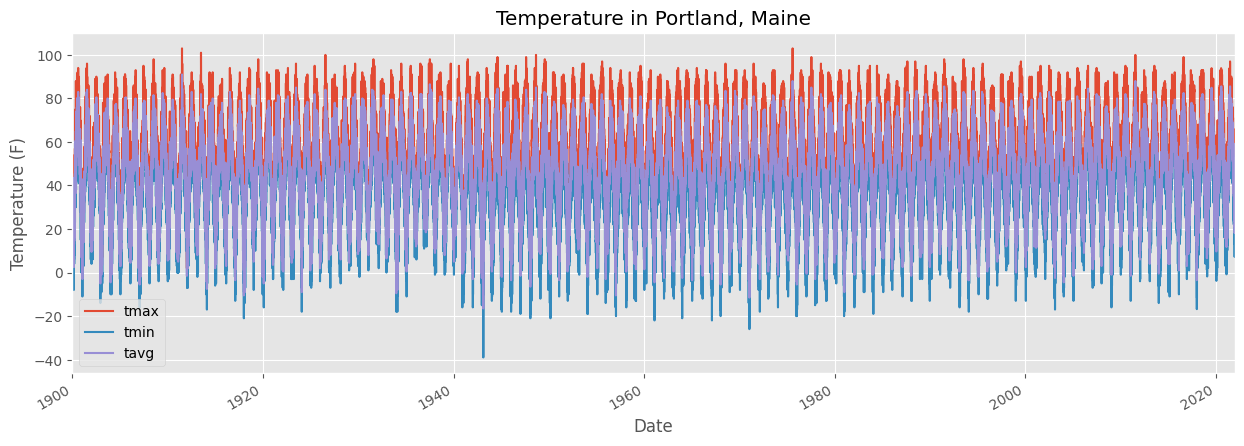

In [33]:
show_plot(location, city, state)

In [16]:
location

,tmax,tmin,prcp,tavg
Date,,,,
1894-01-01,40.0,36.0,0.13,38.00
1894-01-02,40.0,35.0,0.00,37.50
1894-01-03,38.0,30.0,0.04,34.00
1894-01-04,36.0,28.0,0.06,32.00
1894-01-05,37.0,22.0,0.01,29.50
...,...,...,...,...
2021-12-25,37.0,31.1,0.13,34.05
2021-12-26,31.1,20.1,0.26,25.60
2021-12-27,27.1,17.2,0.03,22.15


Aggregate all datasets into one large dataset

Add column for city and state

In [73]:

# Get all the data from all the csv files in the Weather Data folder

# get all the files in the folder
files = glob.glob('Weather Data/US*.csv')

# Get the data from all the files
def get_all_data(files, city_info) -> pd.DataFrame:
    """Get the data from all the files"""
    df = pd.DataFrame()
    for file in tqdm(files):
        cur_df = pd.read_csv(file, parse_dates=['Date'], index_col=0)
        cur_df = cur_df.set_index('Date')
        cur_df = cur_df[cur_df.index.year >= 2017]
        # get average temperature for each month
        cur_df['tavg'] = (cur_df['tmax'] + cur_df['tmin']) / 2
        # add column to cur_df for the city
        city = city_info[city_info['ID'] == str(file.split('/')[1].split('.')[0])]['City'].values[0]
        state = city_info[city_info['ID'] == str(file.split('/')[1].split('.')[0])]['State'].values[0]
        cur_df['City'] = city
        cur_df['State'] = state
        # print(f'Adding data for {city}, {state}, {file}')
        # df = pd.concat([df, cur_df], ignore_index=True)
        df = pd.concat([df, cur_df])
    return df

big_df = get_all_data(files, city_info)
# rename columns
big_df = big_df.rename(columns={'tmax': 'Daily_Max_Temp', 'tmin': 'Daily_Min_Temp', 'prcp': 'Precipitation', 'tavg': 'Daily_Avg_Temp'})
# State to category
big_df['State'] = big_df['State'].astype('category')
# City to category
big_df['City'] = big_df['City'].astype('category')

# Captialize city names
big_df['City'] = big_df['City'].str.title()
# Captialize state names
big_df['State'] = big_df['State'].str.title()
# make column that concatenates city and state
big_df['City_State'] = big_df['City'].astype(str) + ', ' + big_df['State'].astype(str)


100%|██████████| 210/210 [00:18<00:00, 11.34it/s]


In [163]:
# Save big_df to parquet
# big_df.to_parquet('Weather Data/2017-2022.parquet', engine = 'pyarrow')

# Load big_df from parquet
big_df = pd.read_parquet('Weather Data/2017-2022.parquet', engine = 'pyarrow')

In [109]:
big_df

,Daily_Max_Temp,Daily_Min_Temp,Precipitation,Daily_Avg_Temp,City,State,City_State
Date,,,,,,,
2017-01-01,72.0,50.0,0.03,61.00,Savannah,Georgia,"Savannah, Georgia"
2017-01-02,79.0,66.0,0.00,72.50,Savannah,Georgia,"Savannah, Georgia"
2017-01-03,76.0,56.0,0.45,66.00,Savannah,Georgia,"Savannah, Georgia"
2017-01-04,70.0,54.0,0.00,62.00,Savannah,Georgia,"Savannah, Georgia"
2017-01-05,68.0,44.0,0.00,56.00,Savannah,Georgia,"Savannah, Georgia"
...,...,...,...,...,...,...,...
2021-12-27,73.9,51.1,0.00,62.50,Macon,Georgia,"Macon, Georgia"
2021-12-28,79.0,62.1,0.00,70.55,Macon,Georgia,"Macon, Georgia"
2021-12-29,79.0,66.9,0.08,72.95,Macon,Georgia,"Macon, Georgia"


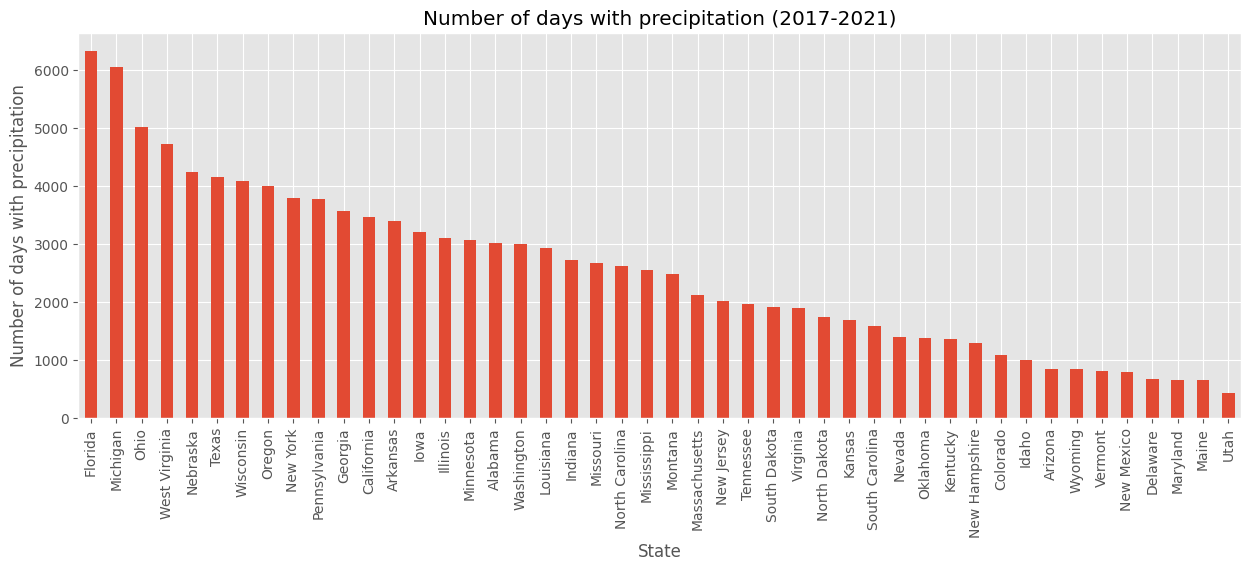

In [84]:
# Number of days with precipitation by state
big_df[big_df['Precipitation'] > 0].groupby('State')['Precipitation'].count().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
plt.title('Number of days with precipitation (2017-2021)')
# axis labels
plt.xlabel('State')
plt.ylabel('Number of days with precipitation')
plt.show()

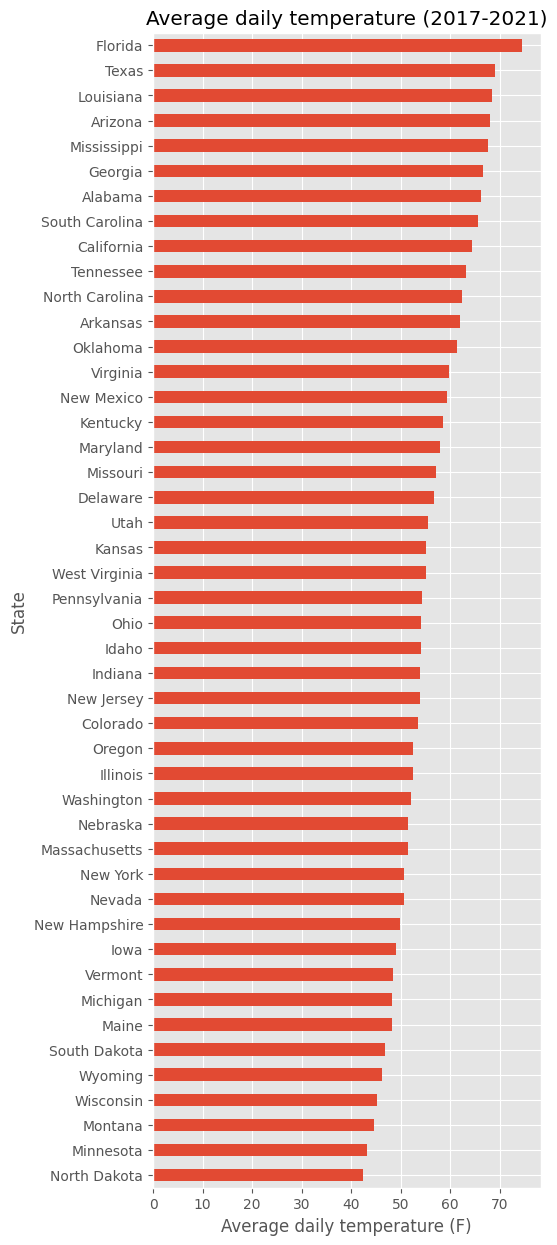

In [95]:
# Hottest and coldest states
big_df.groupby('State')['Daily_Avg_Temp'].mean().sort_values(ascending=True).plot(kind='barh', figsize=(5, 15))
plt.title('Average daily temperature (2017-2021)')
# axis labels
plt.ylabel('State')
plt.xlabel('Average daily temperature (F)')
plt.show()


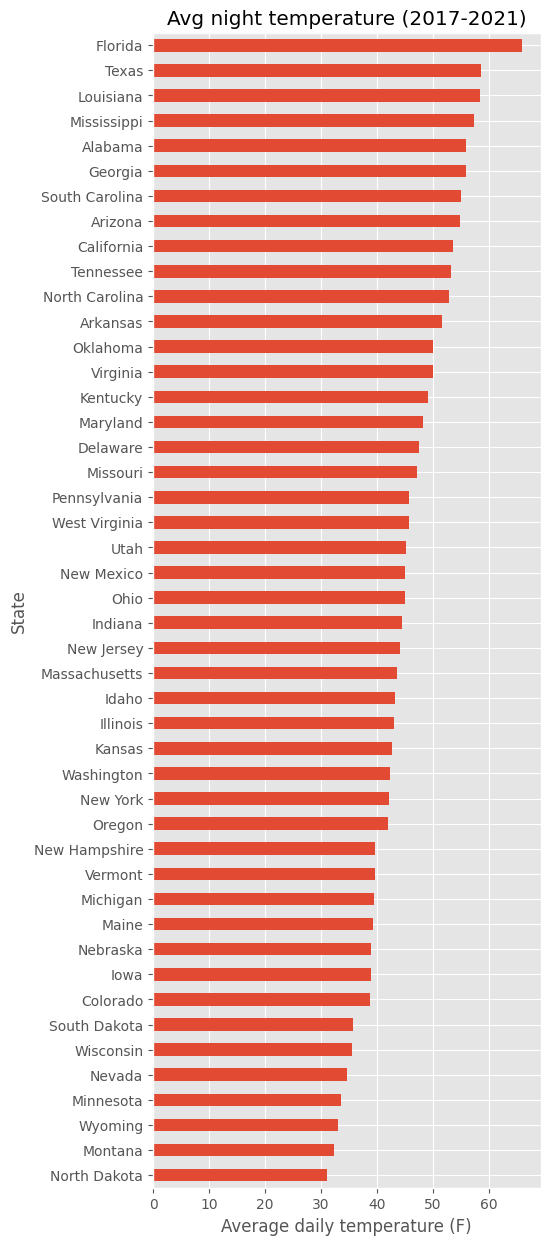

In [97]:
# Hottest and coldest states
big_df.groupby('State')['Daily_Min_Temp'].mean().sort_values(ascending=True).plot(kind='barh', figsize=(5, 15))
plt.title('Avg night temperature (2017-2021)')
# axis labels
plt.ylabel('State')
plt.xlabel('Average daily temperature (F)')
plt.show()

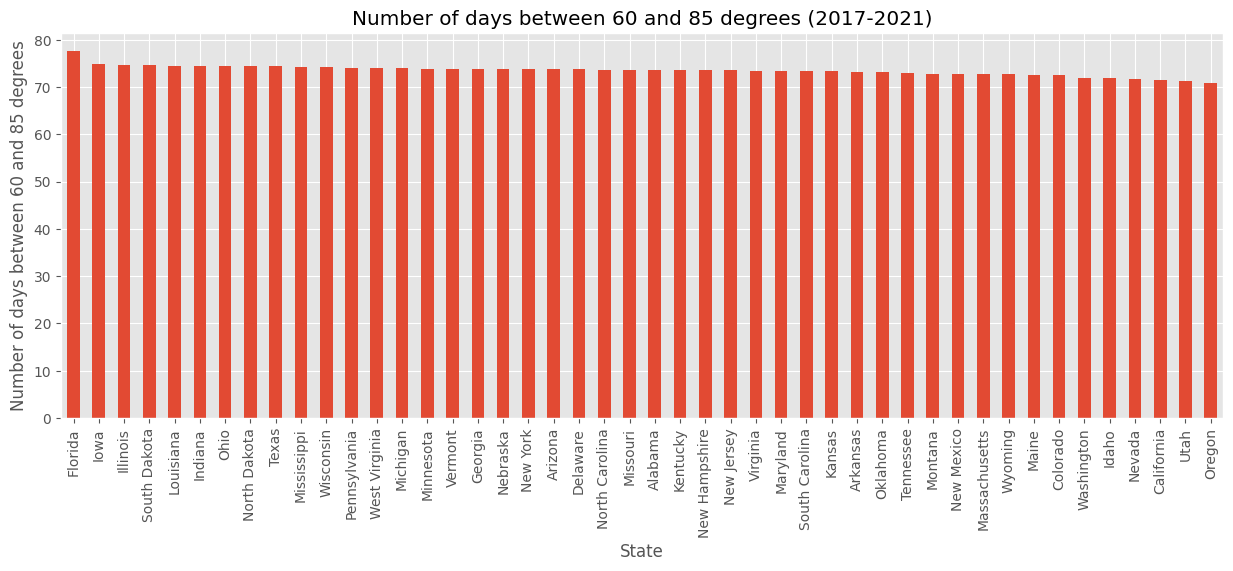

In [100]:
# States with most days between 90 and 100 degrees
big_df[(big_df['Daily_Max_Temp'] >= 60) & (big_df['Daily_Max_Temp'] <= 85)].groupby('State')['Daily_Max_Temp'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
plt.title('Number of days between 60 and 85 degrees (2017-2021)')
# axis labels
plt.xlabel('State')
plt.ylabel('Number of days between 60 and 85 degrees')
plt.show()


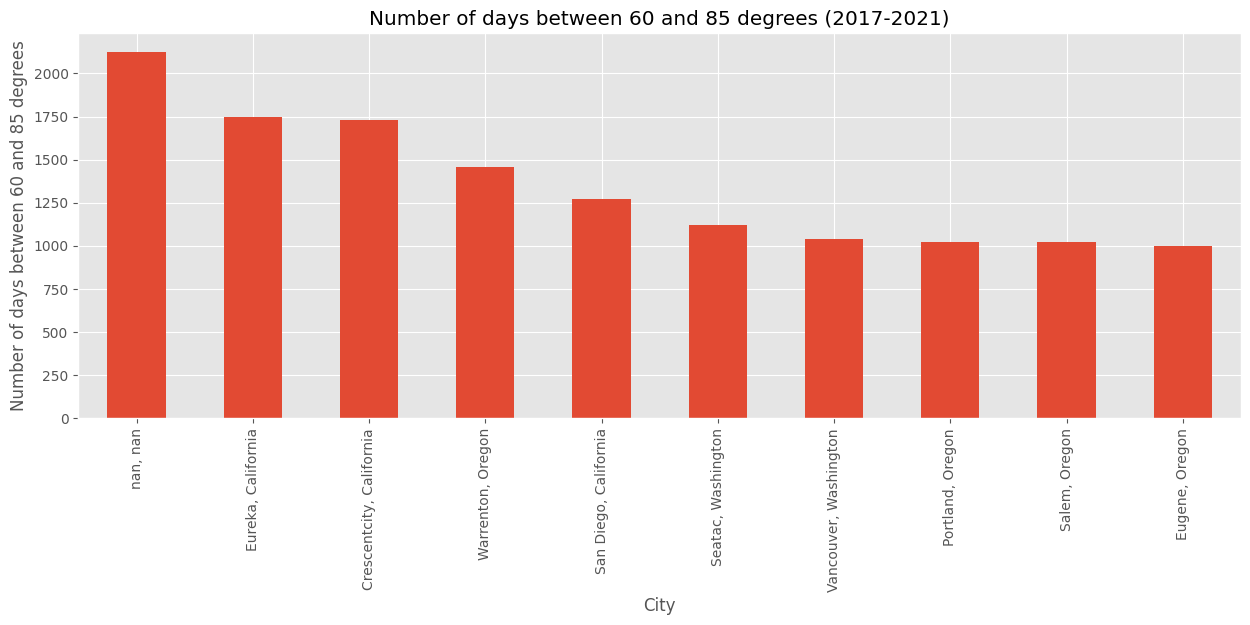

In [118]:
# States with most days between 90 and 100 degrees top 10
big_df[(big_df['Daily_Max_Temp'] >= 50) & (big_df['Daily_Max_Temp'] <= 75)].groupby('City_State')['Daily_Max_Temp'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(15, 5))
plt.title('Number of days between 60 and 85 degrees (2017-2021)')
# axis labels
plt.xlabel('City')
plt.ylabel('Number of days between 60 and 85 degrees')
plt.show()

In [146]:
big_df[big_df['State'] == 'New York']['Daily_Max_Temp'].mean()

59.37905805038336

In [141]:
# Normalized Daily Average Temperature
big_df.groupby('State')['Daily_Avg_Temp'].mean().sort_values(ascending=True)

State
North Dakota      42.397067
Minnesota         43.146314
Montana           44.625685
Wisconsin         45.248970
Wyoming           46.208282
South Dakota      46.756223
Maine             48.188828
Michigan          48.265528
Vermont           48.525465
Iowa              49.056968
New Hampshire     49.799671
Nevada            50.615877
New York          50.751583
Massachusetts     51.407033
Nebraska          51.409082
Washington        52.189221
Illinois          52.488239
Oregon            52.568430
Colorado          53.413436
New Jersey        53.863182
Indiana           53.930567
Idaho             54.058879
Ohio              54.174558
Pennsylvania      54.361046
West Virginia     55.165907
Kansas            55.166176
Utah              55.601369
Delaware          56.743237
Missouri          57.171145
Maryland          58.000958
Kentucky          58.618127
New Mexico        59.269861
Virginia          59.828605
Oklahoma          61.306559
Arkansas          61.931257
North Carolina

In [147]:
big_df[(big_df['Daily_Max_Temp'] >= 50) & (big_df['Daily_Max_Temp'] <= 75)].groupby('City_State')['Daily_Max_Temp'].mean().sort_values(ascending=False).head(10)

City_State
Key West, Florida          71.705263
Miami, Florida             71.307895
Westpalmbeach, Florida     70.842308
Fort Myers, Florida        70.572189
Tampa, Florida             69.062069
Orlando, Florida           68.827682
Yuma, Arizona              68.640879
San Diego, California      68.555162
Los Angeles, California    68.370508
Escondido, California      67.676479
Name: Daily_Max_Temp, dtype: float64

In [150]:
top_10 = big_df[(big_df['Daily_Max_Temp'] >= 50) & (big_df['Daily_Max_Temp'] <= 75)].groupby('City_State')['Daily_Max_Temp'].mean().sort_values(ascending=False).head(10)
# get the latitude and longitude for each city
top_10 = top_10.reset_index()  
top_10 = top_10[top_10['City_State'] != 'nan, nan']         

top_10.merge(city_info, left_on='City_State', right_on='City_State')

,City_State,Daily_Max_Temp,Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate,State,County,City
0,"Key West, Florida",71.705263,KeyWest,USW00012836,24.5550,-81.7522,KEY WEST WB CITY,1871-01-01,1958-02-28,Florida,Monroe County,Key West
1,"Miami, Florida",71.307895,Miami,USW00012839,25.7906,-80.3164,MIAMI,1896-01-01,1939-01-31,Florida,Miami-Dade County,Miami
2,"Westpalmbeach, Florida",70.842308,WestPalmBeach,USW00012844,26.6847,-80.0994,JUPITER-HYPOLUXO,1889-01-01,1999-12-01,Florida,Palm Beach County,Westpalmbeach
3,"Fort Myers, Florida",70.572189,FortMyers,USW00012835,26.5850,-81.8614,FORT MYERS PAGE FIELD,1892-01-01,2021-12-31,Florida,Lee County,Fort Myers
4,"Tampa, Florida",69.062069,Tampa,USW00012842,27.9619,-82.5403,TAMPA WBO,1891-01-01,1940-12-31,Florida,Hillsborough County,Tampa
5,"Orlando, Florida",68.827682,Orlando,USW00012815,28.4339,-81.3250,ORLANDO MUNI AP,1892-01-01,1974-01-31,Florida,Orange County,Orlando
6,"Yuma, Arizona",68.640879,Yuma,USW00003145,32.6500,-114.6167,YUMA WB CITY,1876-01-01,1949-07-31,Arizona,Yuma County,Yuma
7,"San Diego, California",68.555162,SanDiego,USW00023188,32.7336,-117.1831,SAN DIEGO WBO,1851-01-01,1939-06-30,California,San Diego County,San Diego
8,"Los Angeles, California",68.370508,LosAngeles,USW00093134,34.0511,-118.2353,LOS ANGELES DOWNTOWN USC CAMPU,1878-01-01,2021-12-31,California,Los Angeles County,Los Angeles
9,"Escondido, California",67.676479,Escondido,USC00042863,33.1211,-117.0900,Escondido,1894-01-01,1979-03-31,California,San Diego County,Escondido


In [162]:
# Function that displays the best cities on a map
def show_best_cities():
    """Show the best cities on a map"""
    # Get the top 10 cities with the most days between 60 and 85 degrees and fewest above 90 degrees
    top_10 = (big_df[(big_df['Daily_Max_Temp'] >= 50) & (big_df['Daily_Max_Temp'] <= 75)]
            .groupby('City_State')['Daily_Max_Temp']
            .mean()
            .sort_values(ascending=False)
            .head(50))

    top_10 = top_10.reset_index()
    top_10 = top_10[top_10['City_State'] != 'nan, nan']
    top_10 = top_10.merge(city_info, left_on='City_State', right_on='City_State')
    print(top_10)
    # create a map
    m = folium.Map(location=[40, -100], zoom_start=4)
    # add markers to the map
    for i in range(len(top_10)):
        folium.Marker([top_10.iloc[i]['Lat'], top_10.iloc[i]['Lon']], popup=top_10.iloc[i]['City_State']).add_to(m)
    return m

show_best_cities()

                      City_State  Daily_Max_Temp             Name  \
0              Key West, Florida       71.705263          KeyWest   
1                 Miami, Florida       71.307895            Miami   
2         Westpalmbeach, Florida       70.842308    WestPalmBeach   
3            Fort Myers, Florida       70.572189        FortMyers   
4                 Tampa, Florida       69.062069            Tampa   
5               Orlando, Florida       68.827682          Orlando   
6                  Yuma, Arizona       68.640879             Yuma   
7          San Diego, California       68.555162         SanDiego   
8        Los Angeles, California       68.370508       LosAngeles   
9          Escondido, California       67.676479        Escondido   
10              Phoenix, Arizona       67.646436          Phoenix   
11          Gainesville, Florida       67.562385      Gainesville   
12               Tucson, Arizona       67.205556           Tucson   
13              Galveston, Texas  

In [159]:
# Get data by season
def get_season_data(df, season):
    """Get the data for a given season"""
    if season == 'spring':
        return df[(df.index.month >= 3) & (df.index.month <= 5)]
    elif season == 'summer':
        return df[(df.index.month >= 6) & (df.index.month <= 8)]
    elif season == 'fall':
        return df[(df.index.month >= 9) & (df.index.month <= 11)]
    elif season == 'winter':
        return df[(df.index.month == 12) | (df.index.month <= 2)]
    else:
        return None
get_season_data(big_df, 'spring')

,Daily_Max_Temp,Daily_Min_Temp,Precipitation,Daily_Avg_Temp,City,State,City_State
Date,,,,,,,
2017-03-01,86.0,67.0,0.00,76.50,Savannah,Georgia,"Savannah, Georgia"
2017-03-02,72.0,46.0,0.10,59.00,Savannah,Georgia,"Savannah, Georgia"
2017-03-03,68.0,39.0,0.00,53.50,Savannah,Georgia,"Savannah, Georgia"
2017-03-04,62.0,40.0,0.00,51.00,Savannah,Georgia,"Savannah, Georgia"
2017-03-05,69.0,38.0,0.00,53.50,Savannah,Georgia,"Savannah, Georgia"
...,...,...,...,...,...,...,...
2021-05-27,93.9,63.0,0.00,78.45,Macon,Georgia,"Macon, Georgia"
2021-05-28,90.0,66.9,0.65,78.45,Macon,Georgia,"Macon, Georgia"
2021-05-29,86.0,60.1,0.09,73.05,Macon,Georgia,"Macon, Georgia"


In [57]:
cur_df = pd.read_csv('Weather Data/USW00003822.csv', parse_dates=['Date'], index_col=0)
# set index to date
cur_df = cur_df.set_index('Date')

# delete rows that are before 2017
cur_df = cur_df[cur_df.index.year >= 2017]
cur_df

,tmax,tmin,prcp
Date,,,
2015-01-01,61.0,34.0,0.00
2015-01-02,65.0,49.0,0.00
2015-01-03,74.0,57.0,0.00
2015-01-04,77.0,60.0,0.52
2015-01-05,60.0,40.0,0.00
...,...,...,...
2021-12-27,77.0,55.9,0.00
2021-12-28,79.0,60.1,0.00
2021-12-29,79.0,60.1,0.00


In [65]:
big_df.value_counts('City')

City
Springfield       3652
Portland          3652
Columbus          3652
Raleigh           1826
Omaha             1826
                  ... 
Grand Island      1826
Grand Junction    1826
Great Falls       1826
Green             1826
Zaneville         1826
Length: 204, dtype: int64

In [69]:
big_df[big_df['City'] == 'Raleigh']['tmin'].mean()

51.6790251916758